In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: by Jeff Suzuki on 8/25/2023, adapted from paulhuynh's original code
"""

import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import MDS


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.model_selection import train_test_split, KFold

import pandas as pd
import os

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora


from gensim.models.doc2vec import Doc2Vec, TaggedDocument


import numpy as np

In [3]:
###############################################################################
### Function to process documents
###############################################################################
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))

    # Add other words to the set of stopwords
    stop_words.add('would')
    stop_words.add('could')
    
    tokens = [w for w in tokens if not w in stop_words]         
    return tokens

In [53]:
###############################################################################
### Processing text into lists
###############################################################################

# Get the current working directory
current_directory = os.getcwd()

# Construct the file path by joining the current directory with the file name
file_name = "2023_Summer_453_Class_Corpus.csv"
file_path = os.path.join(current_directory, file_name)

data = pd.read_csv(file_path)

#create empty list to store text documents titles
titles=[]

#for loop which appends the DSI title to the titles list
for i in range(0,len(data)):
    temp_text=data['DSI_Title'].iloc[i]
    titles.append(temp_text)

In [7]:
## Adding this for merging purposes in the LDA step. 
data['Document'] = data['Unnamed: 0']

In [8]:
titles

['JS_Doc2_The-Debate-About.docx',
 'JS_Doc1_Should-Joe-Biden.docx',
 'JMK_Doc1_ A-Final-Report-Card-on-the-States-Response-to-COVID-19.docx',
 'JMK_Doc2_Variation-in-US-states-COVID-19-policy-responses.docx',
 'BW_Doc3_Climate_Existential.docx',
 'FM_Doc2_What_Are_Presdent.docx',
 'CGL_Doc3_Western-Goods-Still-Flowing-to-Russia.docx',
 'AT_Doc2_The-Full-Legislative.docx',
 'AK_Doc2_Benefits_Disappear_COVID.docx',
 'CGL_Doc1_US-Allies-Sanction-Russia.docx',
 'JS_Doc3_Remaking-Pollution-Fight.docx',
 'AT_Doc3_With-Just-Two.docx',
 'JS_Doc1_Fact-Sheet-President.docx',
 'FM_Doc1_Democrats__Phalanx_Around.docx',
 'CGL_Doc2_Sanctions-Mark-Tectonic-Shift.docx',
 'AK_Doc1_Biden_End_Emerg.docx',
 'BW_Doc2_Divided_Climate.docx',
 'JS_Doc3_The-Awkward-Issue.docx',
 'BW_Doc1_Climate_Biden.docx',
 'AT_Doc1_Days-Before-The.docx',
 'FM_Doc3_Biden_Faces_Flak.docx',
 'AK_Doc3_Biden_Admin_COVID.docx',
 'JMK_Doc3_Covid’s-deadly-trade-offs-by-the-numbers-How-each-state-has-fared-in-the-pandemic.docx',
 'J

In [9]:
#create empty list to store text documents
text_body=[]

#for loop which appends the text to the text_body list
for i in range(0,len(data)):
    temp_text=data['Text'].iloc[i]
    text_body.append(temp_text)

In [10]:
#Note: the text_body is the unprocessed list of documents read directly form 
#the csv.
text_body

['President Joe Biden recently took a very public tumble after he tripped on a sandbag and fell while onstage at the U.S. Air Force Academy graduation. This has stirred up renewed speculation about his physical and mental fitness due to his advanced age. \n\n\n\nThe fall comes months after he formally announced his bid for reelection in 2024. The president entered the race amid lukewarm support for his reelection bid in polls. An April NBC News poll indicated that a Biden-Trump rematch in 2024 remained unpopular among most voters. Biden\'s announcement may have clarified questions about his candidacy, but questions about his mental competency and advanced age still loom. The president\'s age remained a significant issue for nearly half of the respondents against him running for a second term. \n\n\n\nBiden said he respected that voters have questioned his health and mental faculties due to his age and insisted he took that into account when considering whether to run again. "I took a h

In [11]:
#empty list to store processed documents
processed_text=[]
#for loop to process the text to the processed_text list
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)

In [12]:
#Note: the processed_text is the PROCESSED list of documents read directly form 
#the csv.  Note the list of words is separated by commas.
processed_text

[['president',
  'biden',
  'recently',
  'public',
  'tumble',
  'tripped',
  'sandbag',
  'onstage',
  'force',
  'academy',
  'graduation',
  'stirred',
  'renewed',
  'speculation',
  'physical',
  'mental',
  'fitness',
  'advanced',
  'comes',
  'months',
  'formally',
  'announced',
  'reelection',
  'president',
  'entered',
  'lukewarm',
  'support',
  'reelection',
  'polls',
  'april',
  'indicated',
  'bidentrump',
  'rematch',
  'remained',
  'unpopular',
  'among',
  'voters',
  'bidens',
  'announcement',
  'clarified',
  'questions',
  'candidacy',
  'questions',
  'mental',
  'competency',
  'advanced',
  'still',
  'presidents',
  'remained',
  'significant',
  'issue',
  'nearly',
  'respondents',
  'running',
  'second',
  'biden',
  'respected',
  'voters',
  'questioned',
  'health',
  'mental',
  'faculties',
  'insisted',
  'account',
  'considering',
  'whether',
  'decided',
  'excited',
  'prospects',
  'biden',
  'asked',
  'announcing',
  'campaign',
  'rec

In [13]:
#stitch back together individual words to reform body of text
final_processed_text=[]

for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)

In [16]:
###############################################################################
### Sklearn TFIDF 
###############################################################################
#note the ngram_range will allow you to include multiple words within the TFIDF matrix
#Call Tfidf Vectorizer
Tfidf=TfidfVectorizer(ngram_range=(1,1))

#fit the vectorizer using final processed documents.  The vectorizer requires the 
#stiched back together document.

TFIDF_matrix=Tfidf.fit_transform(final_processed_text)     

#creating datafram from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names_out(), index=titles)

In [17]:
###############################################################################
### Explore TFIDF Values
###############################################################################

average_TFIDF={}
for i in matrix.columns:
    average_TFIDF[i]=np.mean(matrix[i])

average_TFIDF_DF=pd.DataFrame(average_TFIDF,index=[0]).transpose()

average_TFIDF_DF.columns=['TFIDF']

#calculate Q1 and Q3 range
Q1=np.percentile(average_TFIDF_DF, 25)
Q3=np.percentile(average_TFIDF_DF, 75)
IQR = Q3 - Q1
outlier=Q3+(1.5*IQR)


#words that exceed the Q3+IQR*1.5
outlier_list=average_TFIDF_DF[average_TFIDF_DF['TFIDF']>=outlier]

In [20]:
###############################################################################
### Doc2Vec
###############################################################################
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text)]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

doc2vec_df=pd.DataFrame()
for i in range(0,len(processed_text)):
    vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
    doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

doc2vec_df=doc2vec_df.reset_index()

doc_titles={'title': titles}
t=pd.DataFrame(doc_titles)

## I reversed the order of this to make more sense to me.
doc2vec_df=pd.concat([t, doc2vec_df], axis=1)

doc2vec_df=doc2vec_df.drop('index', axis=1)

In [21]:
###############################################################################
### Gensim Word2vec 
###############################################################################

#Note, there are opportunities to use the word2vec matrix to determine words 
#which are similar.  Similar words can be used to create equivalent classes.  
#k-means is not used to group individual words using the Word2Vec output.

#word to vec on the processed text
model_w2v = Word2Vec(processed_text, vector_size=100, window=5, min_count=1, workers=4)

#join all processed DSI words into single list
processed_text_w2v=[]
for i in processed_text:
    for k in i:
        processed_text_w2v.append(k)
        
w2v_words=list(set(processed_text_w2v))

In [23]:
#empty dictionary to store words with vectors
w2v_vectors={}

#for loop to obtain weights for each word
for i in w2v_words:
    temp_vec=model_w2v.wv[i]
    w2v_vectors[i]=temp_vec

In [24]:
#create a final dataframe to view word vectors
w2v_df=pd.DataFrame(w2v_vectors).transpose()

w2v_df

#the following section runs applies the k-means algorithm on the TFIDF matrix.

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
gradual,-0.005821,-0.001427,-0.005578,0.003778,-0.007522,-0.000641,0.006979,-0.001887,0.006367,0.002404,...,-0.000393,-0.007407,0.001886,0.005382,0.004400,-0.008672,0.006138,0.000700,0.003816,0.009775
sunday,0.001064,0.009202,-0.009867,-0.008879,-0.005981,-0.002127,-0.008399,0.007247,-0.002660,-0.005385,...,-0.008684,-0.004012,0.006353,0.005337,0.000563,0.001364,-0.006930,0.003881,-0.004282,0.007186
imposed,0.000048,0.000190,-0.005608,-0.002285,0.002905,0.002129,-0.007042,0.009053,-0.000487,-0.003077,...,-0.008419,-0.003464,0.002383,0.007839,-0.005670,0.001325,0.003331,-0.007956,0.002540,-0.003059
meaning,-0.009933,-0.005332,-0.002537,0.005100,0.001383,-0.009963,-0.002279,0.005228,0.005063,0.001956,...,0.003129,0.001951,0.000885,0.003016,-0.006281,-0.006820,0.003432,-0.004265,-0.007727,0.005270
accurate,-0.002606,0.009295,-0.005044,0.002568,-0.009011,0.004014,0.006536,0.000792,-0.005012,-0.002745,...,-0.006417,0.000687,0.003481,-0.009470,0.000544,0.003512,-0.008359,0.004957,-0.001805,0.003204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
trade,0.000920,-0.001125,-0.002801,0.003344,-0.002230,0.002788,-0.002227,0.004493,-0.005034,-0.000629,...,-0.006914,0.000263,0.007662,-0.006873,0.005394,-0.005651,0.002945,0.005415,0.004945,-0.009086
eventually,-0.008594,0.005227,-0.004359,0.005552,-0.001074,0.004146,0.004596,0.002061,-0.000903,-0.003751,...,0.002918,-0.001584,0.000469,0.008488,-0.001724,0.003915,-0.008973,0.004669,-0.000592,-0.003990
reflects,-0.009137,0.001636,0.001700,-0.003575,0.003493,-0.003583,0.009708,-0.003762,0.004648,0.001228,...,0.006850,0.008254,0.004065,-0.008539,0.004316,-0.003970,0.004688,0.001585,-0.003165,-0.009222
winding,-0.005633,0.002484,0.007980,-0.000733,0.002712,-0.004738,0.004571,-0.003232,-0.009927,-0.005974,...,-0.003995,0.000889,0.001167,-0.001523,-0.004435,0.009115,-0.004650,-0.006401,-0.007975,-0.006502


In [27]:
###############################################################################
### K Means Clustering - TFIDF
###############################################################################
k = 6
n_init = 100

km = KMeans(n_clusters=k, random_state=89, n_init=n_init)
km.fit(TFIDF_matrix)
clusters = km.labels_.tolist()

print('TFIDF clusters:', clusters)

TFIDF clusters: [0, 0, 5, 5, 1, 0, 4, 2, 3, 4, 1, 2, 1, 0, 4, 3, 1, 0, 1, 2, 0, 3, 5, 1]


In [29]:
terms = Tfidf.get_feature_names_out()
Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text']).sort_values(by=['Cluster', 'Doc Name'])

In [31]:
# print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

In [32]:
## Initialize terms_dict
terms_dict=[]

#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}

In [35]:
## Loop to append the cluster terms
for i in range(k):
    print("TFIDF Cluster Terms %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("TFIDF Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles

TFIDF Cluster Terms 0:
 biden
 migrants
 border
 bidens
 harris
 president
 adams
 asylum
 voters
 policy
TFIDF Cluster 0 titles: FM_Doc1_Democrats__Phalanx_Around.docx, FM_Doc2_What_Are_Presdent.docx, FM_Doc3_Biden_Faces_Flak.docx, JS_Doc1_Should-Joe-Biden.docx, JS_Doc2_The-Debate-About.docx, JS_Doc3_The-Awkward-Issue.docx,TFIDF Cluster Terms 1:
 climate
 emissions
 change
 carbon
 reduction
 biden
 revesz
 regulation
 energy
 action
TFIDF Cluster 1 titles: BW_Doc1_Climate_Biden.docx, BW_Doc2_Divided_Climate.docx, BW_Doc3_Climate_Existential.docx, JS_Doc1_Fact-Sheet-President.docx, JS_Doc2_Financial-Regulation-Climate.docx, JS_Doc3_Remaking-Pollution-Fight.docx,TFIDF Cluster Terms 2:
 limit
 spending
 borrowing
 biden
 house
 agreement
 money
 government
 republicans
 borrow
TFIDF Cluster 2 titles: AT_Doc1_Days-Before-The.docx, AT_Doc2_The-Full-Legislative.docx, AT_Doc3_With-Just-Two.docx,TFIDF Cluster Terms 3:
 emergency
 health
 public
 declarations
 emergencies
 vaccines
 house
 na

In [40]:
# Create a list of dictionaries for DataFrame
data = [{'Cluster Number': cluster_num, 'Terms': ', '.join(terms)} for cluster_num, terms in cluster_terms.items()]

# Create a DataFrame from the list of dictionaries
cluster_terms_df = pd.DataFrame(data)

# Export the DataFrame to CSV
cluster_terms_df.to_csv(file_path, index=False)

In [41]:
###############################################################################
### Plotting
###############################################################################

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(TFIDF_matrix)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

C:\Users\jssuz\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


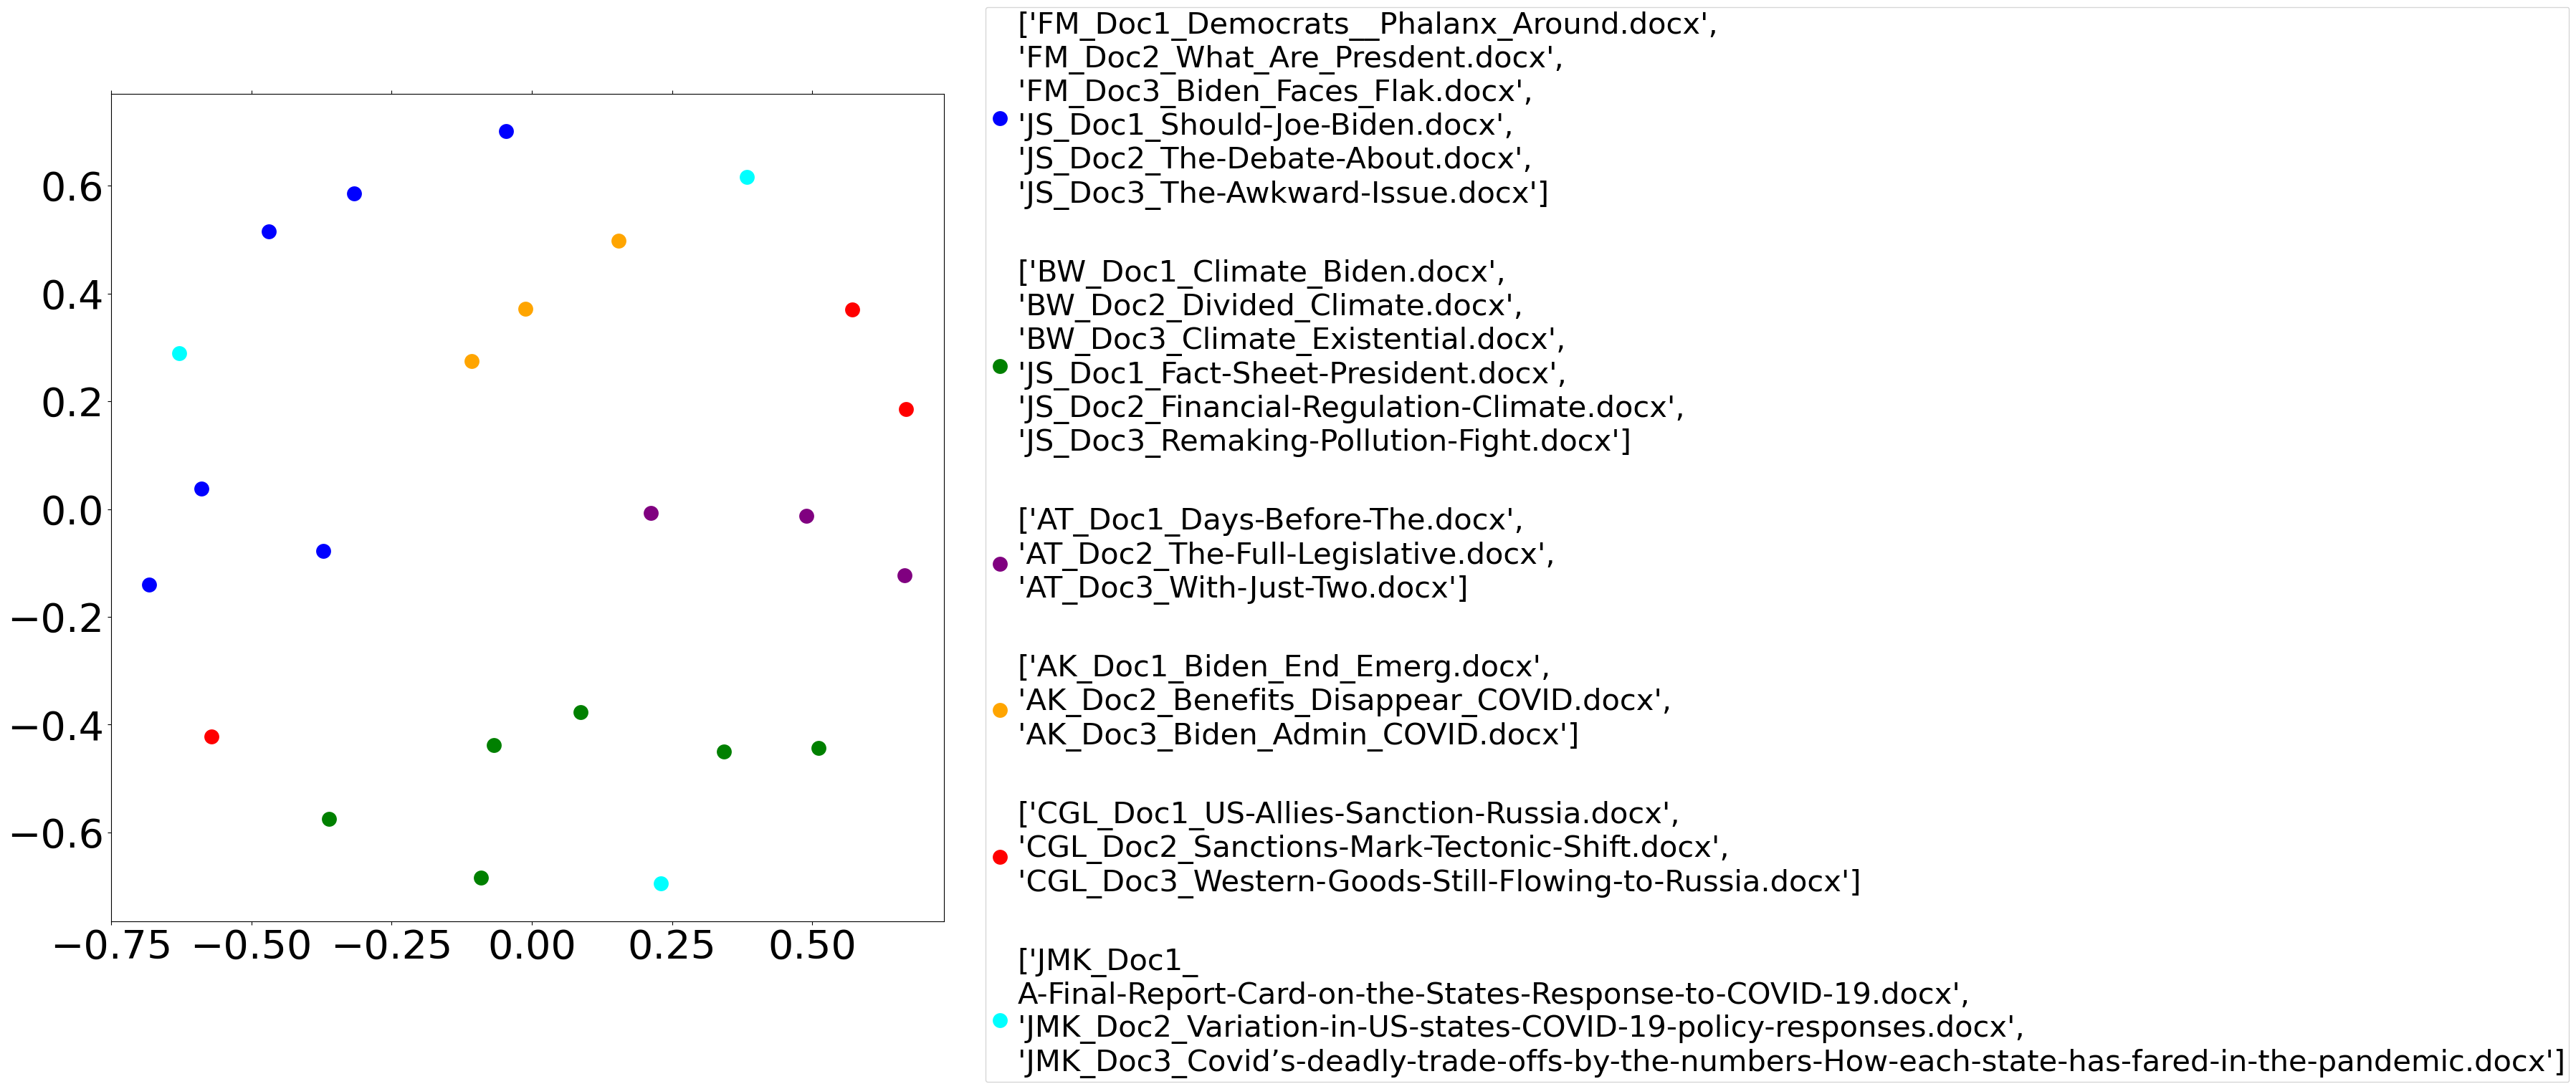

In [42]:
#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {
    0: 'blue',         # Blue
    1: 'green',        # Green
    2: 'purple',       # Purple
    3: 'orange',       # Orange
    4: 'red',          # Red
    5: 'cyan',         # Cyan
}

#set up cluster names using a dict.  
cluster_dict=cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(15, 15)) # set size
# gs = gridspec.GridSpec(2, 1, height_ratios=[20, 1])
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=15,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')
    
# Set up the legend with adjusted font size
legend = ax.legend(loc='lower center', bbox_to_anchor=(2, -0.2), labelspacing=5)

# Loop through legend labels and adjust font size
for label in legend.get_texts():
    label.set_text('\n'.join(label.get_text().split()))
    label.set_fontsize(30)  # Adjust the font size here
    
# Increase the font size of the axes labels
ax.tick_params(axis='both', which='major', labelsize=40)  # Adjust the font size here

# Save the plot as a high-resolution JPG image
plt.savefig('tfidf_cluster_plot.jpg', dpi=500, bbox_inches='tight') 

# Show the plot
plt.show()

In [44]:
#The following section of code is to run the k-means algorithm on the doc2vec outputs.
#note the differences in document clusters compared to the TFIDF matrix.
###############################################################################
### K Means Clustering Doc2Vec
###############################################################################
doc2vec_k_means=doc2vec_df.drop('title', axis=1)

n_init = 100
k = 6
km = KMeans(n_clusters=k, random_state =89, n_init = n_init)
km.fit(doc2vec_k_means)
clusters_d2v = km.labels_.tolist()

Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text']).sort_values(by=['Cluster', 'Doc Name'])

frame

C:\Users\jssuz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,Cluster,Doc Name,Text
7,0,AT_Doc2_The-Full-Legislative.docx,legislative speaker kevin agreement principle ...
18,0,BW_Doc1_Climate_Biden.docx,biden president ambitious climate action platf...
6,0,CGL_Doc3_Western-Goods-Still-Flowing-to-Russia...,group former soviet republics emerged major tr...
1,0,JS_Doc1_Should-Joe-Biden.docx,ageism acceptable better example mainstream co...
8,1,AK_Doc2_Benefits_Disappear_COVID.docx,president biden intends national public health...
11,1,AT_Doc3_With-Just-Two.docx,spare president biden signed legislation satur...
5,1,FM_Doc2_What_Are_Presdent.docx,since office record influx migrants southern b...
20,1,FM_Doc3_Biden_Faces_Flak.docx,washington president bidens border strategy ap...
3,1,JMK_Doc2_Variation-in-US-states-COVID-19-polic...,policymakers passed important pandemic milesto...
23,1,JS_Doc2_Financial-Regulation-Climate.docx,financial regulation climate change climaterel...


In [45]:
frame['Cluster']

7     0
18    0
6     0
1     0
8     1
11    1
5     1
20    1
3     1
23    1
21    2
13    2
2     2
10    2
9     3
22    3
12    3
0     3
15    4
16    4
14    4
17    4
19    5
4     5
Name: Cluster, dtype: int64

In [46]:
#note doc2vec clusters will not have individual words due to the vector representation
#is based on the entire document not indvidual words. As a result, there won't be individual
#word outputs from each cluster.   
for i in range(k):
    temp=frame[frame['Cluster']==i]
    temp_title_list=[]
    for title in temp['Doc Name']:
        temp_title_list.append(title)
    cluster_title[i]=temp_title_list

cluster_title

{0: ['AT_Doc2_The-Full-Legislative.docx',
  'BW_Doc1_Climate_Biden.docx',
  'CGL_Doc3_Western-Goods-Still-Flowing-to-Russia.docx',
  'JS_Doc1_Should-Joe-Biden.docx'],
 1: ['AK_Doc2_Benefits_Disappear_COVID.docx',
  'AT_Doc3_With-Just-Two.docx',
  'FM_Doc2_What_Are_Presdent.docx',
  'FM_Doc3_Biden_Faces_Flak.docx',
  'JMK_Doc2_Variation-in-US-states-COVID-19-policy-responses.docx',
  'JS_Doc2_Financial-Regulation-Climate.docx'],
 2: ['AK_Doc3_Biden_Admin_COVID.docx',
  'FM_Doc1_Democrats__Phalanx_Around.docx',
  'JMK_Doc1_ A-Final-Report-Card-on-the-States-Response-to-COVID-19.docx',
  'JS_Doc3_Remaking-Pollution-Fight.docx'],
 3: ['CGL_Doc1_US-Allies-Sanction-Russia.docx',
  'JMK_Doc3_Covid’s-deadly-trade-offs-by-the-numbers-How-each-state-has-fared-in-the-pandemic.docx',
  'JS_Doc1_Fact-Sheet-President.docx',
  'JS_Doc2_The-Debate-About.docx'],
 4: ['AK_Doc1_Biden_End_Emerg.docx',
  'BW_Doc2_Divided_Climate.docx',
  'CGL_Doc2_Sanctions-Mark-Tectonic-Shift.docx',
  'JS_Doc3_The-Awkward

In [474]:
###############################################################################
### Plotting Doc2vec
###############################################################################
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.

## set parameter
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

## ? what ?
dist = 1 - cosine_similarity(doc2vec_k_means)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

#set up cluster names using a dict.  
cluster_dict=cluster_title    

cluster_dict

C:\Users\jssuz\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


{0: ['AK_Doc2_Benefits_Disappear_COVID.docx',
  'BW_Doc2_Divided_Climate.docx',
  'CGL_Doc1_US-Allies-Sanction-Russia.docx',
  'FM_Doc2_What_Are_Presdent.docx',
  'JS_Doc1_Fact-Sheet-President.docx',
  'JS_Doc2_The-Debate-About.docx'],
 1: ['AT_Doc1_Days-Before-The.docx',
  'AT_Doc2_The-Full-Legislative.docx',
  'CGL_Doc2_Sanctions-Mark-Tectonic-Shift.docx',
  'JMK_Doc3_Covid’s-deadly-trade-offs-by-the-numbers-How-each-state-has-fared-in-the-pandemic.docx'],
 2: ['FM_Doc1_Democrats__Phalanx_Around.docx',
  'FM_Doc3_Biden_Faces_Flak.docx',
  'JMK_Doc1_ A-Final-Report-Card-on-the-States-Response-to-COVID-19.docx',
  'JMK_Doc2_Variation-in-US-states-COVID-19-policy-responses.docx',
  'JS_Doc3_Remaking-Pollution-Fight.docx'],
 3: ['AK_Doc3_Biden_Admin_COVID.docx',
  'CGL_Doc3_Western-Goods-Still-Flowing-to-Russia.docx',
  'JS_Doc1_Should-Joe-Biden.docx',
  'JS_Doc2_Financial-Regulation-Climate.docx'],
 4: ['AT_Doc3_With-Just-Two.docx',
  'BW_Doc1_Climate_Biden.docx',
  'BW_Doc3_Climate_Exi

In [475]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters_d2v, title=range(0,len(clusters)))) 

df

,x,y,label,title
0,0.192670,0.323889,0,0
1,-0.413813,-0.134611,3,1
2,-0.079832,-0.612476,2,2
3,-0.682535,0.366783,2,3
4,0.088952,-0.779259,4,4
5,-0.211192,0.673120,0,5
6,-0.675075,-0.324613,3,6
7,0.399511,-0.128519,1,7
8,-0.157949,0.388484,0,8
9,0.201455,0.669360,0,9


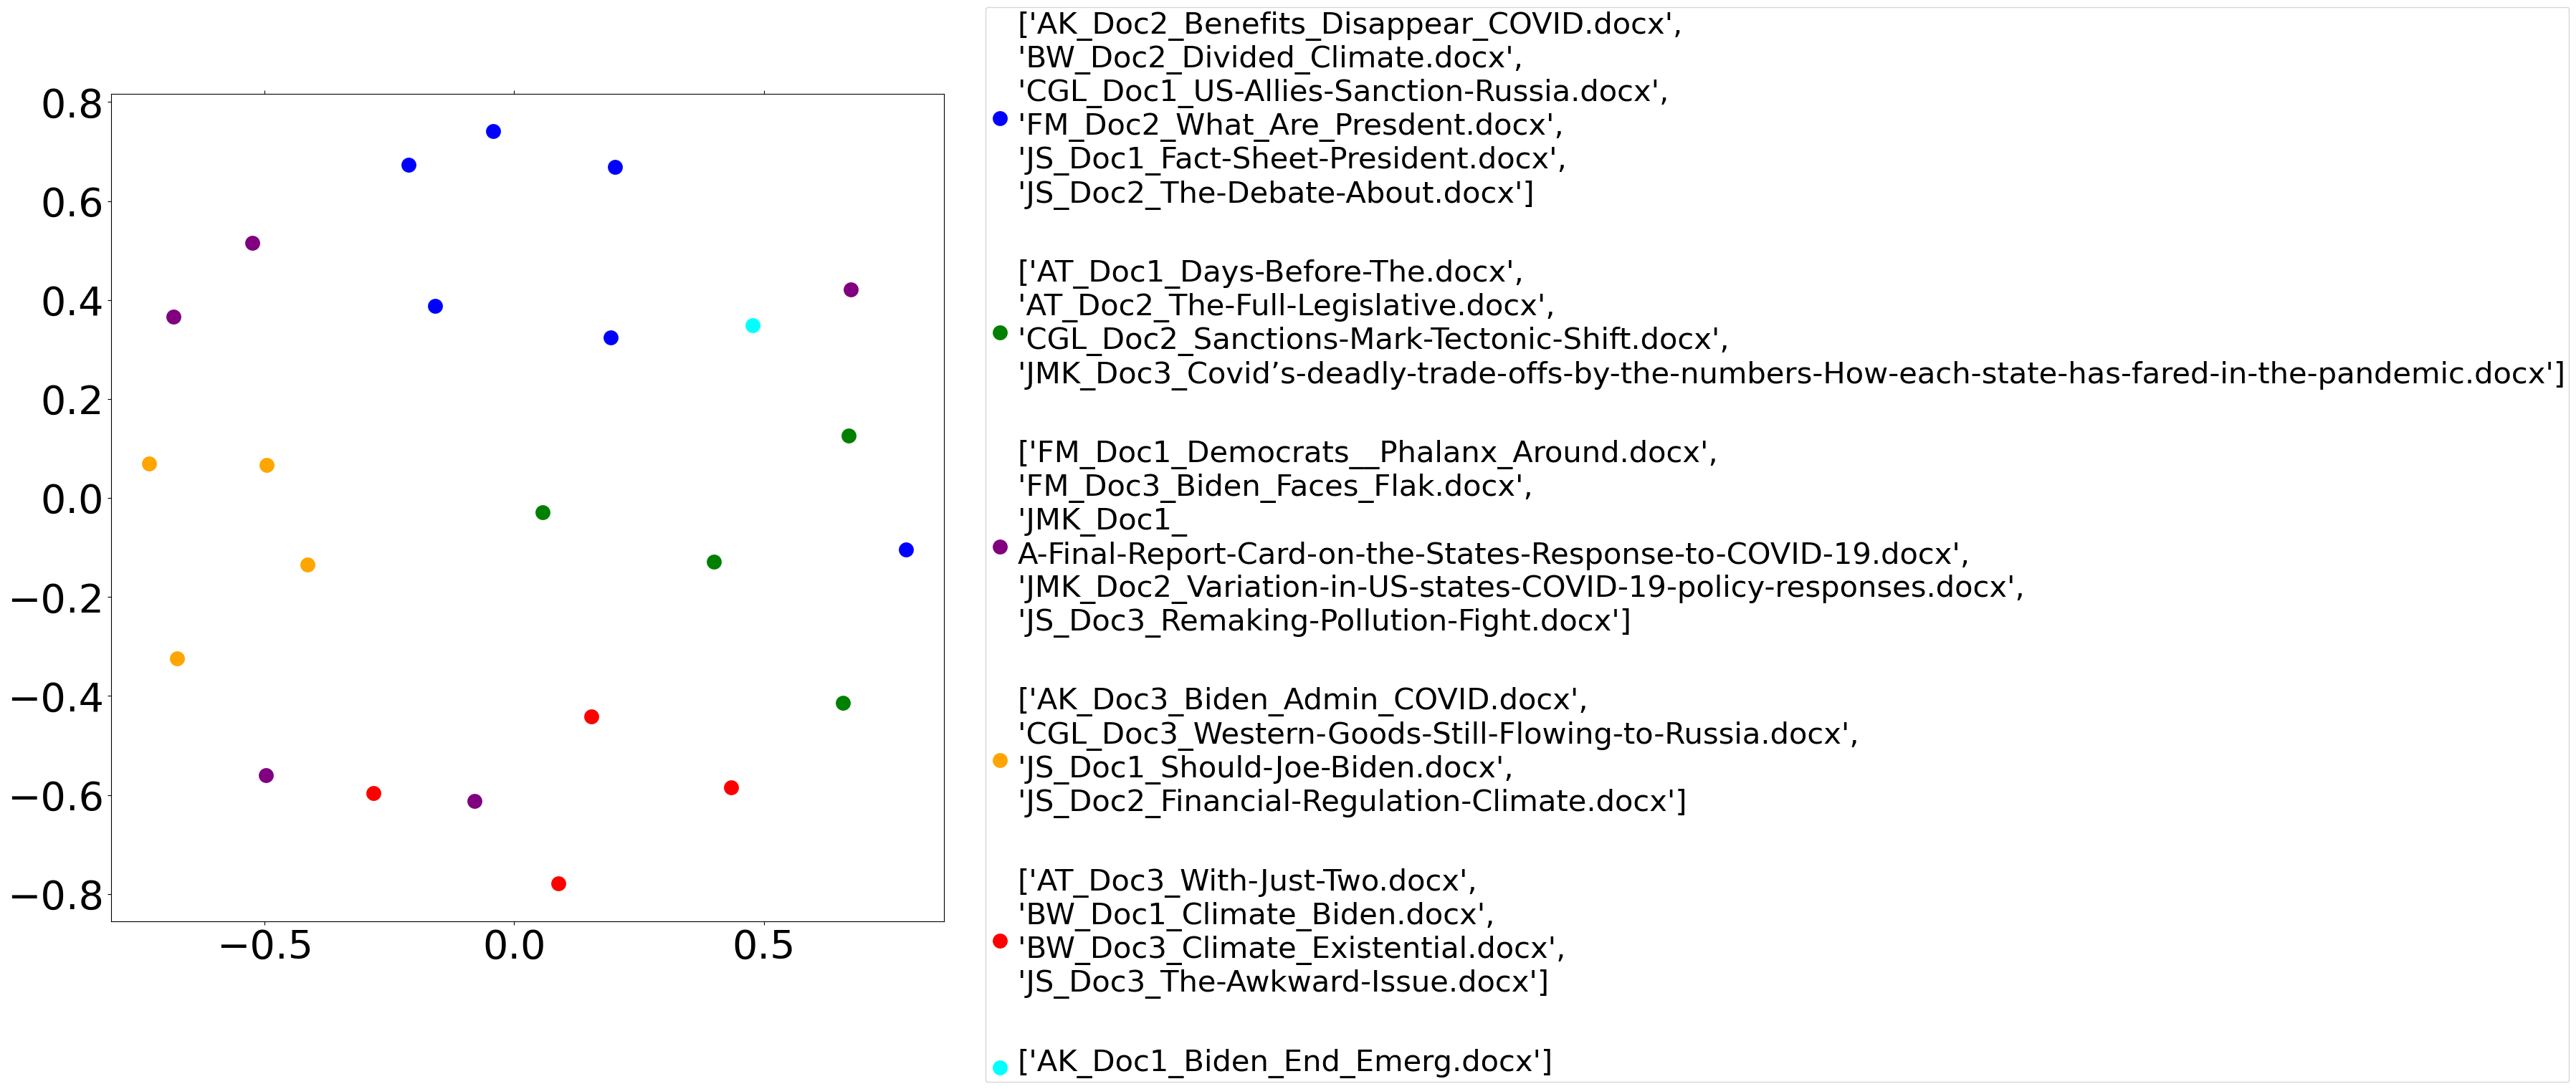

In [477]:
#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {
    0: 'blue',         # Blue
    1: 'green',        # Green
    2: 'purple',       # Purple
    3: 'orange',       # Orange
    4: 'red',          # Red
    5: 'cyan',         # Cyan
}

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(15, 15)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=15,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')
    
# Set up the legend with adjusted font size
legend = ax.legend(loc='lower center', bbox_to_anchor=(2, -0.2), labelspacing=5)

# Loop through legend labels and adjust font size
for label in legend.get_texts():
    label.set_text('\n'.join(label.get_text().split()))
    label.set_fontsize(30)  # Adjust the font size here
    
# Increase the font size of the axes labels
ax.tick_params(axis='both', which='major', labelsize=40)  # Adjust the font size here

# Save the plot as a high-resolution JPG image
plt.savefig('Doc2Vec.jpg', dpi=500, bbox_inches='tight') 

# Show the plot
plt.show()

In [47]:
###############################################################################
###  LDA Code
###############################################################################

#LDA using bag of words
dictionary = corpora.Dictionary(processed_text)
corpus = [dictionary.doc2bow(doc) for doc in processed_text]

ldamodel = LdaMulticore(corpus, num_topics=6, id2word=dictionary, passes=2, workers=2)    

for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))


Topic: 0 
Words: 0.018*"biden" + 0.008*"president" + 0.008*"limit" + 0.007*"policy" + 0.005*"states" + 0.004*"harris" + 0.004*"russian" + 0.004*"financial" + 0.004*"bidens" + 0.004*"sanctions"
Topic: 1 
Words: 0.016*"climate" + 0.014*"emergency" + 0.012*"health" + 0.011*"public" + 0.008*"change" + 0.006*"biden" + 0.006*"emissions" + 0.006*"financial" + 0.006*"administration" + 0.006*"policies"
Topic: 2 
Words: 0.016*"biden" + 0.009*"policy" + 0.007*"migrants" + 0.007*"president" + 0.005*"sanctions" + 0.005*"border" + 0.005*"since" + 0.004*"adams" + 0.004*"house" + 0.004*"white"
Topic: 3 
Words: 0.009*"biden" + 0.008*"russia" + 0.006*"border" + 0.006*"migrants" + 0.005*"administration" + 0.005*"climate" + 0.005*"goods" + 0.005*"western" + 0.005*"trade" + 0.005*"exports"
Topic: 4 
Words: 0.025*"climate" + 0.011*"biden" + 0.011*"emissions" + 0.007*"president" + 0.007*"energy" + 0.006*"carbon" + 0.006*"administration" + 0.006*"action" + 0.006*"reduction" + 0.006*"change"
Topic: 5 
Words: 0

In [35]:
# #LDA using TFIDF
# tfidf = TfidfModel(corpus)
# corpus_tfidf = tfidf[corpus]

# ldamodel = LdaMulticore(corpus_tfidf, num_topics=8, id2word=dictionary, passes=100, workers=2)    

# for idx, topic in ldamodel.print_topics(-1):
#     print('Topic: {} \nWords: {}'.format(idx, topic))

In [48]:
# Assuming you have already trained your LDA model and named it 'ldamodel'
# Assuming 'num_words' is the number of words you want to display for each topic

# Get the top words for each topic
topics_words = ldamodel.show_topics(num_topics=-1, formatted=False)

topics_words

[(0,
  [('biden', 0.01759666),
   ('president', 0.0076181106),
   ('limit', 0.0075860787),
   ('policy', 0.0070738806),
   ('states', 0.0048400974),
   ('harris', 0.0042594615),
   ('russian', 0.004258401),
   ('financial', 0.0041307183),
   ('bidens', 0.0039489814),
   ('sanctions', 0.0039128507)]),
 (1,
  [('climate', 0.016092608),
   ('emergency', 0.013575987),
   ('health', 0.012064761),
   ('public', 0.010924076),
   ('change', 0.008076181),
   ('biden', 0.006239654),
   ('emissions', 0.0061057284),
   ('financial', 0.0060107084),
   ('administration', 0.005961151),
   ('policies', 0.0057440517)]),
 (2,
  [('biden', 0.015584655),
   ('policy', 0.009211834),
   ('migrants', 0.007151384),
   ('president', 0.0069608414),
   ('sanctions', 0.0051253955),
   ('border', 0.004703214),
   ('since', 0.004592551),
   ('adams', 0.0044505657),
   ('house', 0.0044399435),
   ('white', 0.00425477)]),
 (3,
  [('biden', 0.009036148),
   ('russia', 0.008335003),
   ('border', 0.0059195445),
   ('mi

In [52]:
## This is what I was actually looking for. 
keywords = pd.DataFrame(topics_words, columns= ['Topic Number', 'Keywords'])

topic_labels = {
    0: "COVID",
    1: "Immigration",
    2: "Debt Limit",
    3: "Age",
    4: "Russian Sanctions",
    5: "Climate"}

keywords['Topic'] = topic_labels

new_order = ['Topic Number', 'Topic', 'Keywords']
keywords = keywords[new_order]

# Export the DataFrame to CSV
keywords.to_csv(file_path, index=False)

In [426]:
# Get topic distribution for each document
document_topics = [ldamodel.get_document_topics(doc) for doc in corpus]

# Print the topics assigned to each document
for doc_id, topics in enumerate(document_topics):
    print(f"Document {doc_id}:")
    for topic_id, topic_prob in topics:
        print(f"Topic {topic_id}: Probability {topic_prob:.4f}")
    print()

Document 0:
Topic 4: Probability 0.9970

Document 1:
Topic 3: Probability 0.9968

Document 2:
Topic 0: Probability 0.9977

Document 3:
Topic 2: Probability 0.9978

Document 4:
Topic 5: Probability 0.9959

Document 5:
Topic 1: Probability 0.9964

Document 6:
Topic 1: Probability 0.9961

Document 7:
Topic 2: Probability 0.9959

Document 8:
Topic 4: Probability 0.9957

Document 9:
Topic 4: Probability 0.9970

Document 10:
Topic 2: Probability 0.9960

Document 11:
Topic 5: Probability 0.9962

Document 12:
Topic 5: Probability 0.9970

Document 13:
Topic 5: Probability 0.9960

Document 14:
Topic 4: Probability 0.9964

Document 15:
Topic 2: Probability 0.3906
Topic 4: Probability 0.6064

Document 16:
Topic 5: Probability 0.9963

Document 17:
Topic 5: Probability 0.9972

Document 18:
Topic 4: Probability 0.9964

Document 19:
Topic 2: Probability 0.9957

Document 20:
Topic 1: Probability 0.9962

Document 21:
Topic 4: Probability 0.9963

Document 22:
Topic 0: Probability 0.9900

Document 23:
Top

In [427]:
for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.013*"mortality" + 0.010*"pandemic" + 0.009*"states" + 0.008*"state" + 0.008*"economic" + 0.006*"average" + 0.006*"school" + 0.005*"unemployment" + 0.005*"schools" + 0.004*"health"
Topic: 1 
Words: 0.011*"biden" + 0.010*"migrants" + 0.009*"policy" + 0.008*"border" + 0.008*"russia" + 0.006*"administration" + 0.005*"asylum" + 0.005*"goods" + 0.005*"western" + 0.004*"exports"
Topic: 2 
Words: 0.009*"biden" + 0.009*"limit" + 0.008*"policy" + 0.007*"climate" + 0.007*"financial" + 0.006*"government" + 0.006*"administration" + 0.005*"states" + 0.005*"house" + 0.005*"companies"
Topic: 3 
Words: 0.010*"biden" + 0.004*"president" + 0.003*"think" + 0.003*"years" + 0.003*"longevity" + 0.003*"since" + 0.003*"similar" + 0.002*"policy" + 0.002*"older" + 0.002*"political"
Topic: 4 
Words: 0.015*"biden" + 0.011*"health" + 0.010*"emergency" + 0.008*"sanctions" + 0.008*"public" + 0.007*"president" + 0.005*"economic" + 0.005*"climate" + 0.005*"administration" + 0.004*"financial"
Topic: 5

In [428]:
import pandas as pd

document_topics = [ldamodel.get_document_topics(doc) for doc in corpus]
a = []

for doc_id, topics in enumerate(document_topics):
    for topic_id, topic_prob in topics:
        a.append([doc_id, f"Topic {topic_id}", f"Probability {topic_prob:.4f}"])
        
result = pd.merge(LDA_doc_assignments, data['Document'], left_index=True, right_index=True)
        
LDA_doc_assignments = pd.DataFrame(a, columns=["Document", "Topic", "Probability"])
# LDA_doc_assignments['DSI_Title'] = titles
# LDA_doc_assignments
# LDA_doc_assignments.sort_values(by=['Topic', 'DSI_Title'])

result = pd.merge(LDA_doc_assignments, data[['Document', 'DSI_Title']], on='Document').sort_values(by=['Topic Number', 'DSI_Title'])

,Document,Topic,Probability,DSI_Title
2,2,Topic 0,Probability 0.9977,JMK_Doc1_ A-Final-Report-Card-on-the-States-Response-to-COVID-19.docx
23,22,Topic 0,Probability 0.9900,JMK_Doc3_Covid’s-deadly-trade-offs-by-the-numbers-How-each-state-has-fared-in-the-pandemic.docx
6,6,Topic 1,Probability 0.9961,CGL_Doc3_Western-Goods-Still-Flowing-to-Russia.docx
5,5,Topic 1,Probability 0.9964,FM_Doc2_What_Are_Presdent.docx
21,20,Topic 1,Probability 0.9962,FM_Doc3_Biden_Faces_Flak.docx
15,15,Topic 2,Probability 0.3906,AK_Doc1_Biden_End_Emerg.docx
20,19,Topic 2,Probability 0.9957,AT_Doc1_Days-Before-The.docx
7,7,Topic 2,Probability 0.9959,AT_Doc2_The-Full-Legislative.docx
3,3,Topic 2,Probability 0.9978,JMK_Doc2_Variation-in-US-states-COVID-19-policy-responses.docx
24,23,Topic 2,Probability 0.9968,JS_Doc2_Financial-Regulation-Climate.docx


In [431]:
## Show the duplicate entries to show the 'soft' aspect of topic mapping. 
duplicates = result[result.duplicated('DSI_Title', keep=False)]

,Document,Topic,Probability,DSI_Title
15,15,Topic 2,Probability 0.3906,AK_Doc1_Biden_End_Emerg.docx
16,15,Topic 4,Probability 0.6064,AK_Doc1_Biden_End_Emerg.docx


In [60]:
# Export the DataFrame to CSV
duplicates.to_csv(file_path, index=False)